# Allenamento rete ResNet50 per Pose Estimaiton

Questo notebook permette di:
1. **Import e Setup**
2. **Carica dataset LineMOD** con split ufficiale train/test
3. **Inizializza PoseEstimator** (ResNet-50 backbone + regression head)
4. **Training**
5. **Valutazione con ADD metric** sul test set


Esegui sempre sezione 1 e 2 per configurare l'ambiente. Poi scegli:
- **Training completo**
- **Test modello già trainato -> Punto 5**

## 1. Import e Setup

In [ ]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import yaml
import pandas as pd


# Importa il config per usare path e file in altre cartelle
sys.path.insert(0, str(Path.cwd().parent))  # Aggiungi parent al path
from config import Config
from utils.transforms import quaternion_to_rotation_matrix_batch
from models.pose_estimator_endtoend import PoseEstimator
from utils.losses import PoseLoss
from utils.metrics import load_all_models, load_models_info, compute_add_batch, compute_add_batch_gpu

# Usa PROJECT_ROOT dal config
project_root = Config.PROJECT_ROOT
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))


# Configura matplotlib per notebook
%matplotlib inline

print(f"✅ Setup completato")
print(f"📂 Project root: {project_root}")
print(f"🎯 Dataset: LineMOD")
print(f"🖥️  Device: {Config.DEVICE}")
print(f"📊 Image size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"🔢 Batch size: {Config.POSE_BATCH_SIZE}")
print(f"🚀 GPU-accelerated ADD metric: {'✅ Enabled' if Config.DEVICE == 'cuda' else '❌ CPU only'}")

Cache Strategy: full
Numworkers set to 0
Numworkers set to 0
✅ Setup completato
📂 Project root: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation
🎯 Dataset: LineMOD
🖥️  Device: mps
📊 Image size: 224x224
🔢 Batch size: 64
🚀 GPU-accelerated ADD metric: ❌ CPU only


## 2. Carica dataset LineMOD

In [ ]:
# Carica dataset con split ufficiale train/test
print("📦 Caricamento LineMODPoseDataset con split ufficiale...\n")

from dataset.linemod_pose import LineMODPoseDataset
from torch.utils.data import DataLoader

train_dataset = LineMODPoseDataset(
    dataset_root=Config.LINEMOD_ROOT,
    split='train',
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    # aggiungi altri parametri se necessario
    folder_to_class_mapping=getattr(Config, 'FOLDER_ID_TO_CLASS_ID', None)
)
test_dataset = LineMODPoseDataset(
    dataset_root=Config.LINEMOD_ROOT,
    split='test',
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    folder_to_class_mapping=getattr(Config, 'FOLDER_ID_TO_CLASS_ID', None)
)
train_loader = DataLoader(train_dataset, batch_size=Config.POSE_BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS_POSE)
test_loader = DataLoader(test_dataset, batch_size=Config.POSE_BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS_POSE)

print(f"✅ Dataset caricato:")
print(f"   Train batches: {len(train_loader)} (batch_size={Config.POSE_BATCH_SIZE})")
print(f"   Test batches: {len(test_loader)}")
print(f"   Train samples: ~{len(train_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Test samples: ~{len(test_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Crop margin: {Config.POSE_CROP_MARGIN * 100:.0f}%")
print(f"   Output size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"   Workers: {Config.NUM_WORKERS_POSE} (adaptive per {Config.DEVICE})")

📦 Caricamento LineMODPoseDataset con split ufficiale...

✅ Dataset caricato:
   Train batches: 38 (batch_size=64)
   Test batches: 210
   Train samples: ~2432
   Test samples: ~13440
   Crop margin: 15%
   Output size: 224x224
   Workers: 0 (adaptive per mps)


### Visualizza immagini training set con info su traslazione e rotazioni


🖼️  Visualizzazione sample del training set



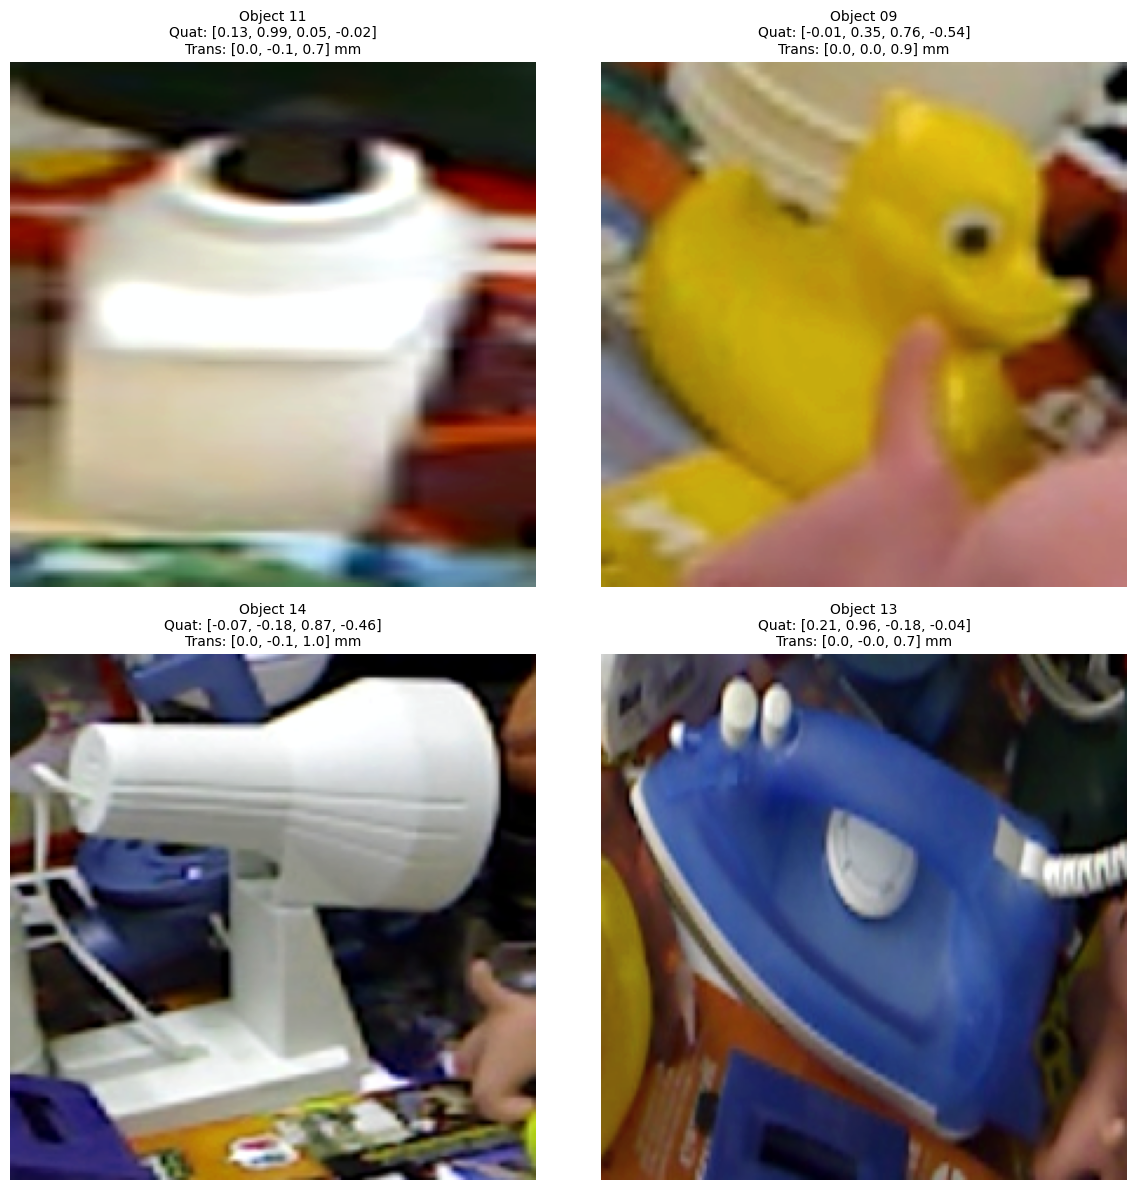

✅ Visualizzazione completata!
   Crop centrato sul bbox con 15% margin
   Quaternion normalizzato (||q|| = 1)
   Translation in millimetri (mm)


In [3]:
# Visualizza alcuni sample del dataset
print("\n🖼️  Visualizzazione sample del training set\n")

# Prendi un batch
batch = next(iter(train_loader))
images = batch['rgb_crop']  # [B, 3, 224, 224]
quaternions = batch['quaternion']  # [B, 4]
translations = batch['translation']  # [B, 3]
obj_ids = batch['obj_id']  # [B]

# Visualizza 4 sample
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i in range(min(4, len(images))):
    # Denormalizza immagine (ImageNet normalization)
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    # Ground truth
    quat = quaternions[i].cpu().numpy()
    trans = translations[i].cpu().numpy()
    obj_id = obj_ids[i].item()
    
    axes[i].imshow(img)
    axes[i].set_title(
        f"Object {obj_id:02d}\n"
        f"Quat: [{quat[0]:.2f}, {quat[1]:.2f}, {quat[2]:.2f}, {quat[3]:.2f}]\n"
        f"Trans: [{trans[0]:.1f}, {trans[1]:.1f}, {trans[2]:.1f}] mm",
        fontsize=10
    )
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"✅ Visualizzazione completata!")
print(f"   Crop centrato sul bbox con {Config.POSE_CROP_MARGIN * 100:.0f}% margin")
print(f"   Quaternion normalizzato (||q|| = 1)")
print(f"   Translation in millimetri (mm)")

## 3. Inizializza Modello PoseEstimator

ResNet-50 backbone (pretrained ImageNet) + regression head (Linear 2048→1024→512→7).
Output: 4D quaternion [qw, qx, qy, qz] + 3D translation [tx, ty, tz]

In [4]:
# Inizializza PoseEstimator con backbone SBLOCCATO (Fase 1 ottimizzazione)
print("🤖 Inizializzazione PoseEstimator...\n")

model = PoseEstimator(
    pretrained=True,
    dropout=Config.POSE_DROPOUT,
    freeze_backbone=False  # ✅ SBLOCCATO per fine-tuning completo
).to(Config.DEVICE)

print(f"✅ Modello inizializzato:")
print(f"   Backbone: ResNet-50 (pretrained ImageNet)")
print(f"   Dropout: {Config.POSE_DROPOUT}")
print(f"   Output: 4D quaternion + 3D translation")

# Conta parametri
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Parametri del modello:")
print(f"   Parametri totali: {total_params:,}")
print(f"   Parametri trainable: {trainable_params:,}")
print(f"   Percentuale trainable: {100 * trainable_params / total_params:.1f}%")

print(f"\n💡 Modalità: Backbone SBLOCCATO (Fase 1)")
print(f"   Tutti i parametri trainable (~25M)")
print(f"   Fine-tuning completo ResNet-50 + regression head")
print(f"   Training più lento ma risultati migliori")

🤖 Inizializzazione PoseEstimator...



/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimator initialized
   Backbone: resnet50 (pretrained=True, frozen=False)
   Feature dim: 2048
   Output: 7 values (4 quaternion + 3 translation)
   Dropout: 0.5
✅ Modello inizializzato:
   Backbone: ResNet-50 (pretrained ImageNet)
   Dropout: 0.5
   Output: 4D quaternion + 3D translation

📊 Parametri del modello:
   Parametri totali: 26,137,671
   Parametri trainable: 26,137,671
   Percentuale trainable: 100.0%

💡 Modalità: Backbone SBLOCCATO (Fase 1)
   Tutti i parametri trainable (~25M)
   Fine-tuning completo ResNet-50 + regression head
   Training più lento ma risultati migliori


### 💡 Opzionale: Carica modello già allenato

Se hai già un checkpoint `best.pt` da un training precedente, esegui la cella seguente per caricarlo e salta direttamente al **Punto 5 (Valutazione)**.

In [9]:
# Carica modello pre-trainato (se disponibile)
# Modifica il nome dell'esperimento per puntare al checkpoint desiderato
CHECKPOINT_NAME = "test1"  # Cambia con il nome del tuo esperimento
checkpoint_path = Config.PROJECT_ROOT / 'checkpoints' / 'pose' / CHECKPOINT_NAME / 'weights' / 'last.pt'

if checkpoint_path.exists():
    print(f"📦 Caricamento checkpoint: {checkpoint_path.relative_to(Config.PROJECT_ROOT)}\n")
    
    # PyTorch 2.6+ default is weights_only=True, but older checkpoints need weights_only=False
    checkpoint = torch.load(checkpoint_path, map_location=Config.DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    best_epoch = checkpoint['epoch'] + 1  # +1 perché epoch è 0-indexed
    
    print(f"✅ Modello caricato con successo!")
    print(f"   Best Epoca: {best_epoch}")
    print(f"   Loss: {checkpoint['loss']:.4f}")
    print(f"   Trans Loss: {checkpoint['loss_trans']:.4f}")
    print(f"   Rot Loss: {checkpoint['loss_rot']:.4f}")
    
    # Carica anche la configurazione del training
    if 'config' in checkpoint:
        print(f"\n📋 Configurazione training:")
        for key, value in checkpoint['config'].items():
            print(f"   {key}: {value}")
    
    # ✅ RICOSTRUISCI HISTORY DAL CSV per visualizzare grafici (fino alla best epoch)
    results_csv = Config.PROJECT_ROOT / 'checkpoints' / 'pose' / CHECKPOINT_NAME / 'results.csv'
    if results_csv.exists():
        df_results = pd.read_csv(results_csv)
        # ✅ IMPORTANTE: Taglia l'history fino alla best epoch (inclusa)
        df_results = df_results.head(best_epoch)
        
        history = {
            'train_loss': df_results['train_loss'].tolist(),
            'train_trans': df_results['train_trans_loss'].tolist(),
            'train_rot': df_results['train_rot_loss'].tolist(),
            'lr_backbone': df_results['lr_backbone'].tolist(),
            'lr_head': df_results['lr_head'].tolist()
        }
        print(f"\n📊 History ricostruito da results.csv (fino a epoca {best_epoch})")
    else:
        print(f"\n⚠️  File results.csv non trovato, grafici training non disponibili")
        history = None
    
    print(f"\n🚀 Puoi ora saltare la cella di training e andare direttamente al Punto 5 (Valutazione)")
else:
    print(f"⚠️  Checkpoint non trovato: {checkpoint_path}")
    print(f"   Esegui prima il training (cella successiva) oppure modifica CHECKPOINT_NAME")

📦 Caricamento checkpoint: checkpoints/pose/test1/weights/last.pt

✅ Modello caricato con successo!
   Best Epoca: 1
   Loss: 1248.1578
   Trans Loss: 238.9300
   Rot Loss: 1.0702

📋 Configurazione training:
   phase: Phase 1 - Optimized
   epochs: 1
   warmup_epochs: 5
   lr_backbone: 5e-06
   lr_head: 0.0001
   batch_size: 64
   accumulation_steps: 2
   effective_batch_size: 128
   use_amp: False
   lambda_trans: 5.0
   lambda_rot: 50.0
   dropout: 0.5
   freeze_backbone: False
   scheduler: ReduceLROnPlateau
   device: mps
   image_size: 224
   crop_margin: 0.15

📊 History ricostruito da results.csv (fino a epoca 1)

🚀 Puoi ora saltare la cella di training e andare direttamente al Punto 5 (Valutazione)


## 4. Training

Training rapido per testare il pipeline. Per risultati migliori, usa 50 epoche con backbone unfrozen.

In [8]:
# ⚡ FASE 1: TRAINING OTTIMIZZATO
# - Backbone sbloccato
# - Learning rate differenziato
# - Warmup + ReduceLROnPlateau


# Risultati per ora bassi:
# Conviene allenare ulteriormente con più epoche o Fase 2 (backbone bloccato)
# Aumentare la lambda di traslazione può aiutare (passa da 1.0 a 5.0 o 10.0)
# Dobbiamo raggiungere una media ADD < 20mm e accuracy > 60/70% per classe


#EPOCHS = Config.POSE_EPOCHS  # ✅ Ridotto: backbone unfrozen converge più velocemente
#WARMUP_EPOCHS = 5  # ✅ Warmup graduale per stabilizzare training

EPOCHS = 1  # Ridotto a 50 per test veloce
WARMUP_EPOCHS = 5  # Ridotto a 5 per test veloce

EXPERIMENT_NAME = "test1"

# Learning rates differenziati
LR_BACKBONE = 5e-6  # da 1e-5 a 5e-6 (più conservativo)
LR_HEAD = 1e-4      # Standard per regression head

# Gradient Accumulation
ACCUMULATION_STEPS = Config.ACCUMULATION_STEPS
EFFECTIVE_BATCH_SIZE = Config.POSE_BATCH_SIZE * ACCUMULATION_STEPS

print(f"⚡ FASE 1 - Training Ottimizzato:")
print(f"   Esperimento: {EXPERIMENT_NAME}")
print(f"   Epoche: {EPOCHS} (+ {WARMUP_EPOCHS} warmup)")
print(f"   Batches per epoca: {len(train_loader)}")
print(f"   🚀 LR Backbone: {LR_BACKBONE:.2e} (fine-tuning delicato)")
print(f"   🚀 LR Head: {LR_HEAD:.2e} (standard)")
print(f"   🚀 Batch size: {Config.POSE_BATCH_SIZE}")
print(f"   🚀 Accumulation steps: {ACCUMULATION_STEPS}")
print(f"   🚀 Effective batch size: {EFFECTIVE_BATCH_SIZE}")
print(f"   Lambda translation: {Config.LAMBDA_TRANS}")
print(f"   Lambda rotation: {Config.LAMBDA_ROT}")
print(f"   Device: {Config.DEVICE}")

# AMP per CUDA
use_amp = Config.DEVICE == 'cuda' and hasattr(torch.cuda, 'amp')
if use_amp:
    print(f"   🚀 AMP enabled (FP16 training)")
    scaler = torch.amp.GradScaler()
else:
    print(f"   ⚠️  AMP disabled (device={Config.DEVICE})")
    scaler = None

print(f"\n💡 Miglioramenti Fase 1:")
print(f"   ✓ Backbone sbloccato: fine-tuning completo (~25M params)")
print(f"   ✓ Learning rate differenziato: backbone 10x più basso")
print(f"   ✓ Warmup: {WARMUP_EPOCHS} epoche per stabilizzare")
print(f"   ✓ ReduceLROnPlateau: LR si riduce solo se loss stagna")
print(f"   ✓ Gradient Accumulation: effective batch {EFFECTIVE_BATCH_SIZE}")

# Setup training con learning rate differenziato
criterion = PoseLoss(
    lambda_trans=Config.LAMBDA_TRANS,
    lambda_rot=Config.LAMBDA_ROT
)

# ✅ OTTIMIZZAZIONE: Learning rate differenziato per backbone e head
optimizer = torch.optim.AdamW([
    {'params': model.backbone.parameters(), 'lr': LR_BACKBONE, 'name': 'backbone'},
    {'params': model.pose_head.parameters(), 'lr': LR_HEAD, 'name': 'head'}
], weight_decay=Config.POSE_WEIGHT_DECAY)

# ✅ OTTIMIZZAZIONE: ReduceLROnPlateau invece di CosineAnnealing
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,      # Riduce LR di 50% quando stagna
    patience=5,      # Attende 5 epoche prima di ridurre
    min_lr=1e-7      # LR minimo
)

# Crea struttura cartelle
checkpoint_dir = project_root / 'checkpoints' / 'pose' / EXPERIMENT_NAME
checkpoint_dir.mkdir(parents=True, exist_ok=True)

weights_dir = checkpoint_dir / 'weights'
weights_dir.mkdir(exist_ok=True)

# Salva configurazione
config_file = checkpoint_dir / 'args.yaml'
training_config = {
    'phase': 'Phase 1 - Optimized',
    'epochs': EPOCHS,
    'warmup_epochs': WARMUP_EPOCHS,
    'lr_backbone': float(LR_BACKBONE),
    'lr_head': float(LR_HEAD),
    'batch_size': Config.POSE_BATCH_SIZE,
    'accumulation_steps': ACCUMULATION_STEPS,
    'effective_batch_size': EFFECTIVE_BATCH_SIZE,
    'use_amp': use_amp,
    'lambda_trans': Config.LAMBDA_TRANS,
    'lambda_rot': Config.LAMBDA_ROT,
    'dropout': Config.POSE_DROPOUT,
    'freeze_backbone': False,
    'scheduler': 'ReduceLROnPlateau',
    'device': str(Config.DEVICE),
    'image_size': Config.POSE_IMAGE_SIZE,
    'crop_margin': Config.POSE_CROP_MARGIN,
}
with open(config_file, 'w') as f:
    yaml.dump(training_config, f, default_flow_style=False)

print(f"\n📁 Checkpoint directory: {checkpoint_dir}")
print(f"   ├── args.yaml")
print(f"   ├── results.csv")
print(f"   └── weights/")
print(f"       ├── best.pt")
print(f"       └── last.pt\n")

# Training loop con warmup
history = {'train_loss': [], 'train_trans': [], 'train_rot': [], 'lr_backbone': [], 'lr_head': []}
best_loss = float('inf')
best_epoch = 0

results_file = checkpoint_dir / 'results.csv'
with open(results_file, 'w') as f:
    f.write('epoch,train_loss,train_trans_loss,train_rot_loss,lr_backbone,lr_head\n')

for epoch in range(EPOCHS):
    # ✅ WARMUP: Aumenta gradualmente LR nelle prime WARMUP_EPOCHS
    if epoch < WARMUP_EPOCHS:
        warmup_factor = (epoch + 1) / WARMUP_EPOCHS
        for param_group in optimizer.param_groups:
            if param_group['name'] == 'backbone':
                param_group['lr'] = LR_BACKBONE * warmup_factor
            else:  # head
                param_group['lr'] = LR_HEAD * warmup_factor
        print(f"🔥 Warmup epoch {epoch+1}/{WARMUP_EPOCHS} - LR scale: {warmup_factor:.2f}")
    
    model.train()
    epoch_loss = 0
    epoch_trans = 0
    epoch_rot = 0
    
    optimizer.zero_grad()
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    for batch_idx, batch in enumerate(pbar):
        # Move to device
        images = batch['rgb_crop'].to(Config.DEVICE)
        gt_quaternion = batch['quaternion'].to(Config.DEVICE)
        gt_translation = batch['translation'].to(Config.DEVICE)
        
        # Forward pass with AMP (if enabled)
        if use_amp:
            with torch.cuda.amp.autocast():
                pred_quaternion, pred_translation = model(images)
                loss_dict = criterion(
                    pred_quaternion, pred_translation,
                    gt_quaternion, gt_translation
                )
                loss = loss_dict['total'] / ACCUMULATION_STEPS
        else:
            pred_quaternion, pred_translation = model(images)
            loss_dict = criterion(
                pred_quaternion, pred_translation,
                gt_quaternion, gt_translation
            )
            loss = loss_dict['total'] / ACCUMULATION_STEPS
        
        # Backward pass
        if use_amp:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        
        # Update weights every ACCUMULATION_STEPS
        if (batch_idx + 1) % ACCUMULATION_STEPS == 0 or (batch_idx + 1) == len(train_loader):
            if use_amp:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
        
        # Update metrics
        epoch_loss += loss_dict['total'].item()
        epoch_trans += loss_dict['trans'].item()
        epoch_rot += loss_dict['rot'].item()
        
        # Update progress bar
        current_lr_backbone = optimizer.param_groups[0]['lr']
        current_lr_head = optimizer.param_groups[1]['lr']
        pbar.set_postfix({
            'loss': f"{loss_dict['total'].item():.4f}",
            'trans': f"{loss_dict['trans'].item():.4f}",
            'rot': f"{loss_dict['rot'].item():.2f}",
            'lr_bb': f"{current_lr_backbone:.2e}",
            'lr_hd': f"{current_lr_head:.2e}"
        })
    
    # Epoch statistics
    num_batches = len(train_loader)
    avg_loss = epoch_loss / num_batches
    avg_trans = epoch_trans / num_batches
    avg_rot = epoch_rot / num_batches
    
    current_lr_backbone = optimizer.param_groups[0]['lr']
    current_lr_head = optimizer.param_groups[1]['lr']
    
    history['train_loss'].append(avg_loss)
    history['train_trans'].append(avg_trans)
    history['train_rot'].append(avg_rot)
    history['lr_backbone'].append(current_lr_backbone)
    history['lr_head'].append(current_lr_head)
    
    # Salva risultati epoch
    with open(results_file, 'a') as f:
        f.write(f"{epoch+1},{avg_loss:.6f},{avg_trans:.6f},{avg_rot:.6f},{current_lr_backbone:.8e},{current_lr_head:.8e}\n")
    
    print(f"\n📊 Epoch {epoch+1}/{EPOCHS} Summary:")
    print(f"   Loss: {avg_loss:.4f} | Trans: {avg_trans:.4f} | Rot: {avg_rot:.2f}")
    print(f"   LR Backbone: {current_lr_backbone:.2e} | LR Head: {current_lr_head:.2e}")
    
    # ✅ SCHEDULER: Riduci LR se loss stagna (dopo warmup)
    if epoch >= WARMUP_EPOCHS:
        scheduler.step(avg_loss)
    
    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_epoch = epoch
        best_path = weights_dir / 'best.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'loss_trans': avg_trans,
            'loss_rot': avg_rot,
            'config': training_config,
        }, best_path)
        print(f"   💾 Best model salvato: {best_path.relative_to(project_root)}")
    
    # Save last model
    last_path = weights_dir / 'last.pt'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
        'loss_trans': avg_trans,
        'loss_rot': avg_rot,
        'config': training_config,
    }, last_path)
    
    # ✅ EARLY STOPPING: Ferma se non migliora per 10 epoche
    if epoch - best_epoch >= 10 and epoch >= WARMUP_EPOCHS:
        print(f"\n⚠️  Early stopping! Loss non migliora da {epoch - best_epoch} epoche")
        print(f"   Best loss: {best_loss:.4f} @ epoch {best_epoch + 1}")
        break
    
    print()

print(f"✅ Training Fase 1 completato!")
print(f"   Best loss: {best_loss:.4f} @ epoch {best_epoch + 1}")
print(f"   Modelli salvati in: {checkpoint_dir.relative_to(project_root)}")
print(f"   📁 Struttura:")
print(f"      ├── args.yaml")
print(f"      ├── results.csv")
print(f"      └── weights/")
print(f"          ├── best.pt (best loss: {best_loss:.4f})")
print(f"          └── last.pt (last epoch)")

print(f"\n🚀 Ottimizzazioni Fase 1:")
print(f"   • Backbone sbloccato: fine-tuning completo")
print(f"   • Learning rate differenziato: {LR_BACKBONE:.2e} (bb) / {LR_HEAD:.2e} (head)")
print(f"   • Warmup: {WARMUP_EPOCHS} epoche")
print(f"   • ReduceLROnPlateau: adattivo")
print(f"   • Early stopping: patience 10 epoche")
print(f"   • Gradient Accumulation: {ACCUMULATION_STEPS}x")

# Aggiorna variabile globale per celle successive
checkpoint_path = weights_dir / 'best.pt'

⚡ FASE 1 - Training Ottimizzato:
   Esperimento: test1
   Epoche: 1 (+ 5 warmup)
   Batches per epoca: 38
   🚀 LR Backbone: 5.00e-06 (fine-tuning delicato)
   🚀 LR Head: 1.00e-04 (standard)
   🚀 Batch size: 64
   🚀 Accumulation steps: 2
   🚀 Effective batch size: 128
   Lambda translation: 5.0
   Lambda rotation: 50.0
   Device: mps
   ⚠️  AMP disabled (device=mps)

💡 Miglioramenti Fase 1:
   ✓ Backbone sbloccato: fine-tuning completo (~25M params)
   ✓ Learning rate differenziato: backbone 10x più basso
   ✓ Warmup: 5 epoche per stabilizzare
   ✓ ReduceLROnPlateau: LR si riduce solo se loss stagna
   ✓ Gradient Accumulation: effective batch 128
✅ PoseLoss initialized
   λ_trans: 5.0
   λ_rot: 50.0

📁 Checkpoint directory: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/test1
   ├── args.yaml
   ├── results.csv
   └── weights/
       ├── best.pt
       └── last.pt

🔥 Warmup epoch 1/5 - LR scale: 0.20


Epoch 1/1: 100%|██████████| 38/38 [00:43<00:00,  1.15s/it, loss=885.6798, trans=164.3991, rot=1.27, lr_bb=1.00e-06, lr_hd=2.00e-05] 



📊 Epoch 1/1 Summary:
   Loss: 1248.1578 | Trans: 238.9300 | Rot: 1.07
   LR Backbone: 1.00e-06 | LR Head: 2.00e-05
   💾 Best model salvato: checkpoints/pose/test1/weights/best.pt

✅ Training Fase 1 completato!
   Best loss: 1248.1578 @ epoch 1
   Modelli salvati in: checkpoints/pose/test1
   📁 Struttura:
      ├── args.yaml
      ├── results.csv
      └── weights/
          ├── best.pt (best loss: 1248.1578)
          └── last.pt (last epoch)

🚀 Ottimizzazioni Fase 1:
   • Backbone sbloccato: fine-tuning completo
   • Learning rate differenziato: 5.00e-06 (bb) / 1.00e-04 (head)
   • Warmup: 5 epoche
   • ReduceLROnPlateau: adattivo
   • Early stopping: patience 10 epoche
   • Gradient Accumulation: 2x


📈 Visualizzazione training curves



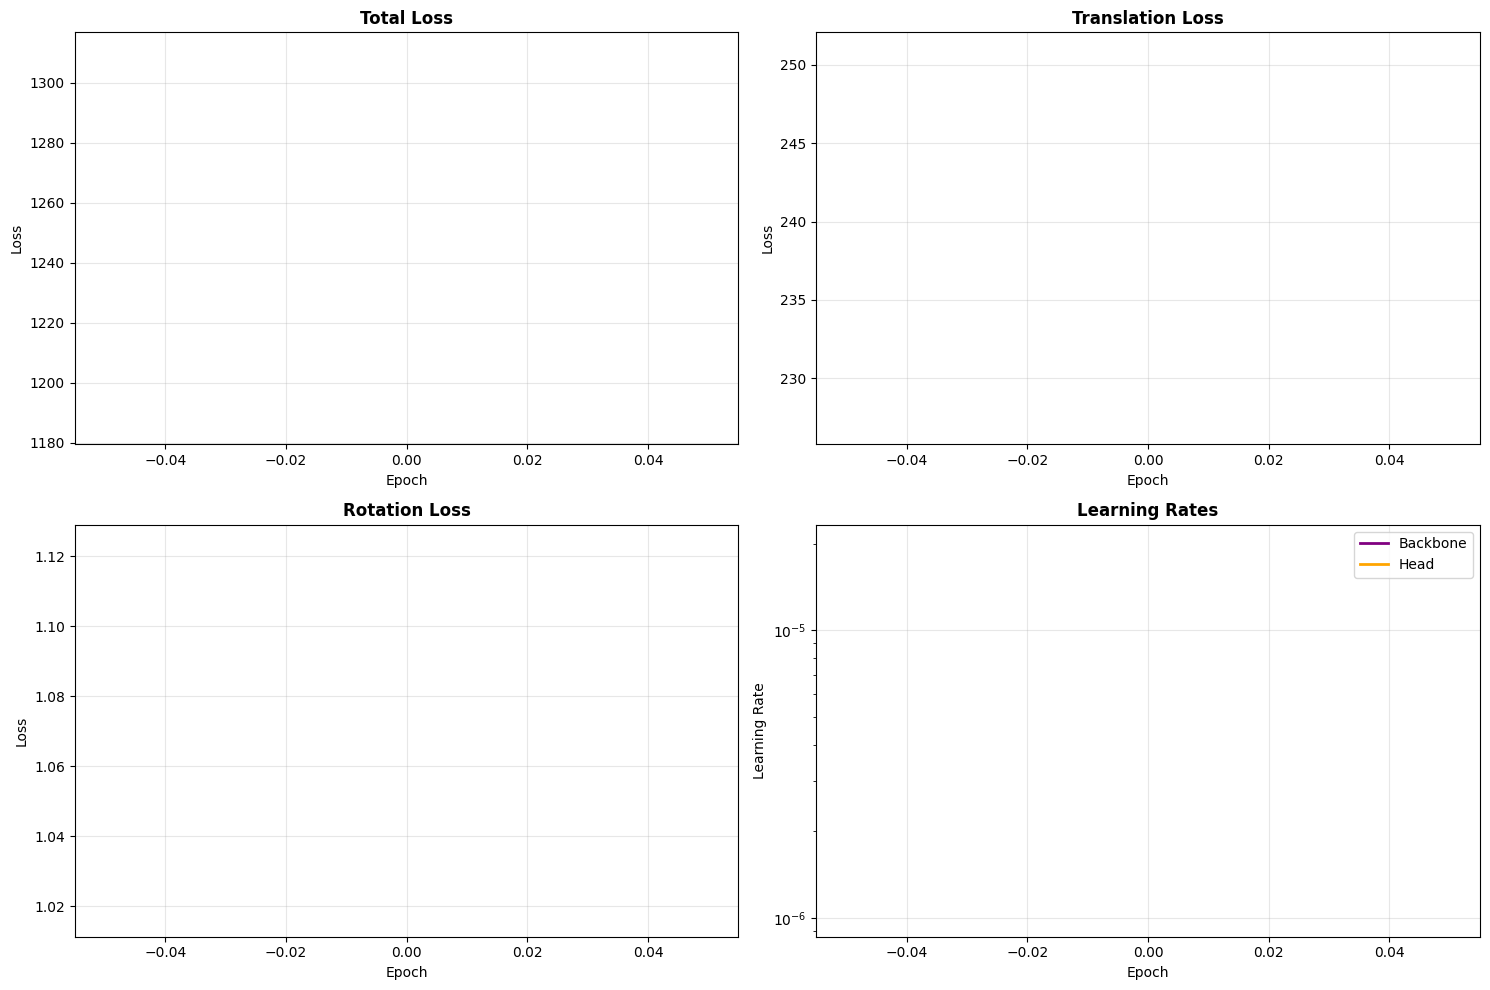

✅ Visualizzazione completata!

💡 Nota: Grafico LR mostra l'adattamento dinamico del learning rate


In [10]:
# Visualizza training curves con learning rates
print("📈 Visualizzazione training curves\n")

# Verifica che history esista
if 'history' not in globals() or history is None:
    print("⚠️  Variable 'history' non trovata!")
    print("   Esegui prima il training oppure carica un checkpoint con results.csv")
else:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Total loss
    axes[0, 0].plot(history['train_loss'], 'b-', linewidth=2)
    axes[0, 0].set_title('Total Loss', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Translation loss
    axes[0, 1].plot(history['train_trans'], 'g-', linewidth=2)
    axes[0, 1].set_title('Translation Loss', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Rotation loss
    axes[1, 0].plot(history['train_rot'], 'r-', linewidth=2)
    axes[1, 0].set_title('Rotation Loss', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning rates
    if 'lr_backbone' in history and 'lr_head' in history:
        axes[1, 1].plot(history['lr_backbone'], 'purple', linewidth=2, label='Backbone')
        axes[1, 1].plot(history['lr_head'], 'orange', linewidth=2, label='Head')
        axes[1, 1].set_title('Learning Rates', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualizzazione completata!")
    print(f"\n💡 Nota: Grafico LR mostra l'adattamento dinamico del learning rate")

## 5. Test e Valutazione su sample del Test Set (rotazione + traslazione)

### ⚡ Test rapido su subset (opzionale)

Se vuoi un'anteprima veloce prima di calcolare su tutto il test set (che può richiedere 15-20 minuti), esegui questa cella per testare su un piccolo subset.

In [11]:
# Test rapido su primo 10% del test set per vedere performance indicative
SUBSET_SIZE = len(test_loader) // 10  # 10% del test set

models_dict = load_all_models()
models_info = load_models_info(Config.MODELS_INFO_PATH)

all_pred_quaternions = []
all_pred_translations = []
all_gt_quaternions = []
all_gt_translations = []
all_obj_ids = []

use_gpu_metric = Config.DEVICE == 'cuda'

model.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(test_loader, desc="Test rapido (10%)", total=SUBSET_SIZE)):
        if batch_idx >= SUBSET_SIZE:
            break
            
        images = batch['rgb_crop'].to(Config.DEVICE)
        gt_quaternions = batch['quaternion'].to(Config.DEVICE)
        gt_translations = batch['translation'].to(Config.DEVICE)
        obj_ids = batch['obj_id'].cpu().numpy()
        
        pred_quaternions, pred_translations = model(images)
        
        if use_gpu_metric:
            all_pred_quaternions.append(pred_quaternions)
            all_pred_translations.append(pred_translations)
            all_gt_quaternions.append(gt_quaternions)
            all_gt_translations.append(gt_translations)
        else:
            all_pred_quaternions.append(pred_quaternions.cpu())
            all_pred_translations.append(pred_translations.cpu())
            all_gt_quaternions.append(gt_quaternions.cpu())
            all_gt_translations.append(gt_translations.cpu())
        all_obj_ids.append(obj_ids)

# Concatena e calcola ADD
all_pred_quaternions = torch.cat(all_pred_quaternions, dim=0)
all_pred_translations = torch.cat(all_pred_translations, dim=0)
all_gt_quaternions = torch.cat(all_gt_quaternions, dim=0)
all_gt_translations = torch.cat(all_gt_translations, dim=0)
all_obj_ids = np.concatenate(all_obj_ids, axis=0)

pred_R = quaternion_to_rotation_matrix_batch(all_pred_quaternions)
gt_R = quaternion_to_rotation_matrix_batch(all_gt_quaternions)

print(f"Calcolo ADD su {len(all_obj_ids)} sample (10% del test set)...")
if use_gpu_metric:
    results_subset = compute_add_batch_gpu(pred_R, all_pred_translations, gt_R, all_gt_translations,
                                           all_obj_ids, models_dict, models_info)
else:
    results_subset = compute_add_batch(pred_R, all_pred_translations, gt_R, all_gt_translations,
                                       all_obj_ids, models_dict, models_info)

# Mostra risultati indicativi
add_values = np.array(results_subset['add_values'])
is_correct = np.array(results_subset['is_correct'])
print(f"\n📊 Risultati indicativi (10% test set):")
print(f"   Media ADD: {add_values.mean():.2f} mm")
print(f"   Accuracy: {is_correct.mean()*100:.1f}%")
print(f"\n💡 Per risultati completi, esegui la cella successiva (richiede ~15-20 min)")


✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points


Test rapido (10%): 100%|██████████| 21/21 [00:12<00:00,  1.72it/s]


Calcolo ADD su 1344 sample (10% del test set)...

📊 Risultati indicativi (10% test set):
   Media ADD: 48.02 mm
   Accuracy: 0.4%

💡 Per risultati completi, esegui la cella successiva (richiede ~15-20 min)


### ⚡ Test su tutto il set

Test set (Può richiedere 20-25 minuti su cuda)

In [ ]:
# Calcola le metriche ADD su tutto il test set e salva i risultati in 'results' (rotazione + traslazione)

# Carica i modelli 3D e info oggetti
models_dict = load_all_models()
models_info = load_models_info(Config.MODELS_INFO_PATH)

all_pred_quaternions = []
all_pred_translations = []
all_gt_quaternions = []
all_gt_translations = []
all_obj_ids = []

# ✅ Determina se usare GPU o CPU per la metrica ADD
use_gpu_metric = Config.DEVICE == 'cuda' 

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Valutazione su test set"):
        images = batch['rgb_crop'].to(Config.DEVICE)
        gt_quaternions = batch['quaternion'].to(Config.DEVICE)
        gt_translations = batch['translation'].to(Config.DEVICE)
        obj_ids = batch['obj_id'].cpu().numpy()
        
        # ✅ Modello end-to-end restituisce (quaternion, translation)
        pred_quaternions, pred_translations = model(images)
        
        # ✅ Mantieni su GPU se usiamo compute_add_batch_gpu, altrimenti CPU
        if use_gpu_metric:
            all_pred_quaternions.append(pred_quaternions)
            all_pred_translations.append(pred_translations)
            all_gt_quaternions.append(gt_quaternions)
            all_gt_translations.append(gt_translations)
        else:
            all_pred_quaternions.append(pred_quaternions.cpu())
            all_pred_translations.append(pred_translations.cpu())
            all_gt_quaternions.append(gt_quaternions.cpu())
            all_gt_translations.append(gt_translations.cpu())
        all_obj_ids.append(obj_ids)

# Concatena tutti i batch
print("concatenazione batch")
all_pred_quaternions = torch.cat(all_pred_quaternions, dim=0)
all_pred_translations = torch.cat(all_pred_translations, dim=0)
all_gt_quaternions = torch.cat(all_gt_quaternions, dim=0)
all_gt_translations = torch.cat(all_gt_translations, dim=0)
all_obj_ids = np.concatenate(all_obj_ids, axis=0)

# Converti quaternioni in matrici di rotazione
print("conversione da quaternioni a matrici di rotazione")
pred_R = quaternion_to_rotation_matrix_batch(all_pred_quaternions)
gt_R = quaternion_to_rotation_matrix_batch(all_gt_quaternions)

# Calcola le metriche ADD complete (rotazione + traslazione)
print("calcolo ADD con rotazione e traslazione")
if use_gpu_metric:
    print("   → Usando versione GPU-accelerated")
    results = compute_add_batch_gpu(
        pred_R, all_pred_translations, gt_R, all_gt_translations,
        all_obj_ids, models_dict, models_info
    )
else:
    print("   → Usando versione CPU")
    results = compute_add_batch(
        pred_R, all_pred_translations, gt_R, all_gt_translations,
        all_obj_ids, models_dict, models_info
    )
results['obj_ids'] = all_obj_ids
print("✅ Calcolate metriche ADD (rotazione + traslazione) su tutto il test set. Pronto per tabella e grafico.")


### Tabella: Media ADD e Accuracy per Classe

La tabella seguente riporta la media dell'errore ADD e l'accuracy (percentuale di pose corrette) per ciascuna classe (oggetto) del dataset LineMOD.

In [12]:
# Calcola e mostra la tabella delle performance per classe

# Risultati per ora bassi:
# Conviene allenare ulteriormente con più epoche o Fase 2 (backbone bloccato)
# Aumentare la lambda di traslazione può aiutare (passa da 1.0 a 5.0 o 10.0)
# Dobbiamo raggiungere una media ADD < 20mm e accuracy > 60/70% per classe

results = globals().get('results', None)
if results is None:
    print("⚠️  Devi prima calcolare la metrica ADD su tutto il test set e salvare i risultati in 'results'.")
else:
    obj_ids = np.array(results['obj_ids'])
    add_values = np.array(results['add_values'])
    is_correct = np.array(results['is_correct'])
    data = []
    for obj_id, obj_name in Config.LINEMOD_OBJECTS.items():
        mask = obj_ids == obj_id
        if np.sum(mask) == 0:
            continue
        mean_add = add_values[mask].mean()
        acc = is_correct[mask].mean() * 100
        data.append({
            'Classe': f"{obj_id:02d} - {obj_name.get('name')}",
            'Media ADD': f"{mean_add:.2f}",
            'Accuracy (%)': f"{acc:.1f}"
        })
    df = pd.DataFrame(data)
    display(df)
    print("\nMedia globale ADD:", f"{add_values.mean():.2f}")
    print("Accuracy globale (%):", f"{is_correct.mean()*100:.1f}")

⚠️  Devi prima calcolare la metrica ADD su tutto il test set e salvare i risultati in 'results'.


### Grafico: Media ADD per Classe

Il grafico seguente mostra la media dell'errore ADD per ciascuna classe, per un confronto visivo immediato delle performance del modello sui diversi oggetti.

In [ ]:
# Grafico a barre delle medie ADD per classe
if results is None:
    print("⚠️  Devi prima calcolare la metrica ADD su tutto il test set e salvare i risultati in 'results'.")
else:
    obj_ids = np.array(results['obj_ids'])
    add_values = np.array(results['add_values'])
    class_names = []
    mean_adds = []
    for obj_id, obj_name in Config.LINEMOD_OBJECTS.items():
        mask = obj_ids == obj_id
        if np.sum(mask) == 0:
            continue
        class_names.append(f"{obj_id:02d} - {obj_name.get('name')}")
        mean_adds.append(add_values[mask].mean())
    plt.figure(figsize=(10, 5))
    bars = plt.bar(class_names, mean_adds, color='skyblue')
    plt.ylabel('Media ADD')
    plt.xlabel('Classe')
    plt.title('Media ADD per Classe (LineMOD)')
    plt.xticks(rotation=45, ha='right')
    for bar, value in zip(bars, mean_adds):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{value:.2f}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()
